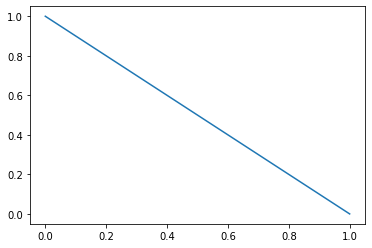

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline  

plt.plot([0,1],[1,0])
plt.show()
def model_pipeline(b):
    """
    Move into very reduced model,
    a method for running tests on models.
    """
    attrs = {k:np.mean(v) for k,v in self.model_parameters.MODEL_PARAMS[b].items()}
    pre_model = DataTC()
    pre_model.attrs = attrs
    pre_model.backend = b
    dtc = dtc_to_rheo(pre_model)
    dtc = format_tests(dtc)
    vm,_ = inject_and_plot_passive_model(pre_model.attrs,b)
    axs[cnt].plot(vm.times,vm.magnitude)
    axs[cnt].set_title(b)
    cnt+=1

    if len(vm)>0 and vm is not None:
        boolean = True
    else:
        boolean = False
    self.assertTrue(boolean)


In [16]:

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuronunit.models.reduced import ReducedModel
from neuronunit.optimisation.model_parameters import path_params
from neuronunit.optimisation import model_parameters as modelp

#from neuronunit.optimization.model_parameters import model_params, path_params
LEMS_MODEL_PATH = path_params['model_path']
#import neuronunit.optimization as opt
import quantities as pq





# From OSB models
mparams = {}
mparams['a'] = 0.03
mparams['b'] = -2
mparams['C'] = 100
mparams['c'] = -50 
mparams['vr'] = -60
mparams['vt'] = -40
mparams['vPeak'] = 35
mparams['k'] = 0.7
mparams['d'] = 100



# compile and discard a model, to initialize the JIT
and discard, this is to purge a space and make model speed comparison fair.


In [17]:
import numpy as np
import time
from neuronunit.models.very_reduced_sans_lems import VeryReducedModel
model = None
model = VeryReducedModel(backend ='RAW')
print(model)
print(mparams)
model.set_attrs(mparams)
iparams = {}
iparams['injected_square_current'] = {}
iparams['injected_square_current']['amplitude'] = 10*pq.pA
#['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
DELAY = 0# 100.0*pq.ms
DURATION = 520*pq.ms
iparams['injected_square_current']['delay'] = DELAY
iparams['injected_square_current']['duration'] = int(DURATION)
print(iparams)
model.inject_square_current(iparams)



{'a': 0.03, 'b': -2, 'C': 100, 'c': -50, 'vr': -60, 'vt': -40, 'vPeak': 35, 'k': 0.7, 'd': 100}
{'injected_square_current': {'amplitude': array(10.) * pA, 'delay': 0, 'duration': 520}}


AnalogSignal with 1 channels of length 72000; units mV; datatype float64 
sampling rate: 100.0
time: 0.0 to 0.72

# Vanilla parameters model to model check (succeeds).
# RAW is significantly faster

In [18]:
times = []

for current in [60,70,85,100]:
    # compile a model and discard

    model = None
    model = VeryReducedModel(backend = ('RAW'))
    model.set_attrs(mparams)
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0# 100.0*pq.ms
    DURATION = 520*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = int(DURATION)

    model.inject_square_current(iparams)



NEURON units                                           NeuroML units   
v0 = -60 (mV),  vr = -60 (mV) ,                        mparams['vr'] = -60
k = 7.0E-4 (uS / mV),                                  mparams['k'] = 0.7                ***different
vt = -40 (mV)
vpeak = 35 (mV)                 mparams['vPeak'] = 35
a = 0.030000001 (kHz) [ms-1],   mparams['a'] = 0.03
b = -0.002 (uS),                mparams['b'] = -2
c = -50 (mV),                   mparams['c'] = -50  
d = 0.1 (nA) --MATLAB pA        mparams['d'] = 100  ******** pA
C = 1.0E-4 (microfarads)        mparams['C'] = 100 ******** co faraday)

In [19]:
import collections
# Fast spiking cannot be reproduced as it requires modifications to the standard Izhi equation,
# which are expressed in this mod file.
# https://github.com/OpenSourceBrain/IzhikevichModel/blob/master/NEURON/izhi2007b.mod

from collections import OrderedDict
type2007 = collections.OrderedDict([
  #              C    k     vr  vt vpeak   a      b   c    d  celltype
  ('RS',        (100, 0.7,  -60, -40, 35, 0.03,   -2, -50,  100,  1)),
  ('IB',        (150, 1.2,  -75, -45, 50, 0.01,   5, -56,  130,   2)),
  ('CH',        (50,  1.5,  -60, -40, 25, 0.03,   1, -40,  150,   3)),
  ('LTS',       (100, 1.0,  -56, -42, 40, 0.03,   8, -53,   20,   4)),
  ('FS',        (20,  1.0,  -55, -40, 25, 0.2,   -2, -45,  -55,   5)),
  ('TC',        (200, 1.6,  -60, -50, 35, 0.01,  15, -60,   10,   6)),
  ('TC_burst',  (200, 1.6,  -60, -50, 35, 0.01,  15, -60,   10,   6)),
  ('RTN',       (40,  0.25, -65, -45,  0, 0.015, 10, -55,   50,   7)),
  ('RTN_burst', (40,  0.25, -65, -45,  0, 0.015, 10, -55,   50,   7))])

import numpy as np
param_dict = OrderedDict([(k,[]) for k in ['C','k','vr','vt','vPeak','a','b','c','d']])
#OrderedDict
for i,k in enumerate(param_dict.keys()):
    for v in type2007.values():
        param_dict[k].append(v[i])

explore_param = {k:(np.min(v),np.max(v)) for k,v in param_dict.items()}
param_ranges = OrderedDict(explore_param)


#IB = mparams[param_dict['IB']]
IB = {}
TC = {}
CH = {}
RTN_burst = {}
for k,v in param_dict.items():
    IB[k] = v[1]
    CH[k] = v[2]
    TC[k] = v[5]
    RTN_burst[k] = v[-2]
    
RTN_burstN = copy.copy(RTN_burst)
TCN = copy.copy(TC)
IBN = copy.copy(IB)
CHN = copy.copy(CH)

tstop = 100*pq.ms
IinRange = [73.2,100,200,400]


# From OSB models
mparams = {}
mparams['a'] = 0.03
mparams['b'] = -2
mparams['C'] = 100
mparams['c'] = -50 
mparams['vr'] = -60
mparams['vt'] = -40
mparams['vPeak'] = 35
mparams['k'] = 0.7
mparams['d'] = 100


# FROM the MOD file.
vanilla_NRN = {}
#vanilla_NRN['v0'] = -60# (mV)
vanilla_NRN['k'] = 7.0E-4# (uS / mV)
vanilla_NRN['vr'] = -60# (mV)
vanilla_NRN['vt'] = -40# (mV)
vanilla_NRN['vPeak'] = 35# (mV)
vanilla_NRN['a'] = 0.03# (kHz)
vanilla_NRN['b'] = -0.002# (uS)
vanilla_NRN['c'] = -50# (mV)
vanilla_NRN['d'] = 0.1# (nA)
vanilla_NRN['C'] = 1.0E-4# (microfarads)

m2m = {}
for k,v in vanilla_NRN.items():
    m2m[k] = vanilla_NRN[k]/mparams[k]


def translate(input_dic,m2m):
    input_dic['vpeak'] = input_dic['vPeak']
    input_dic.pop('vPeak', None)     
    input_dic.pop('dt', None)        
    for k,v in input_dic.items():
        input_dic[k] = v * m2m[k]
    return input_dic


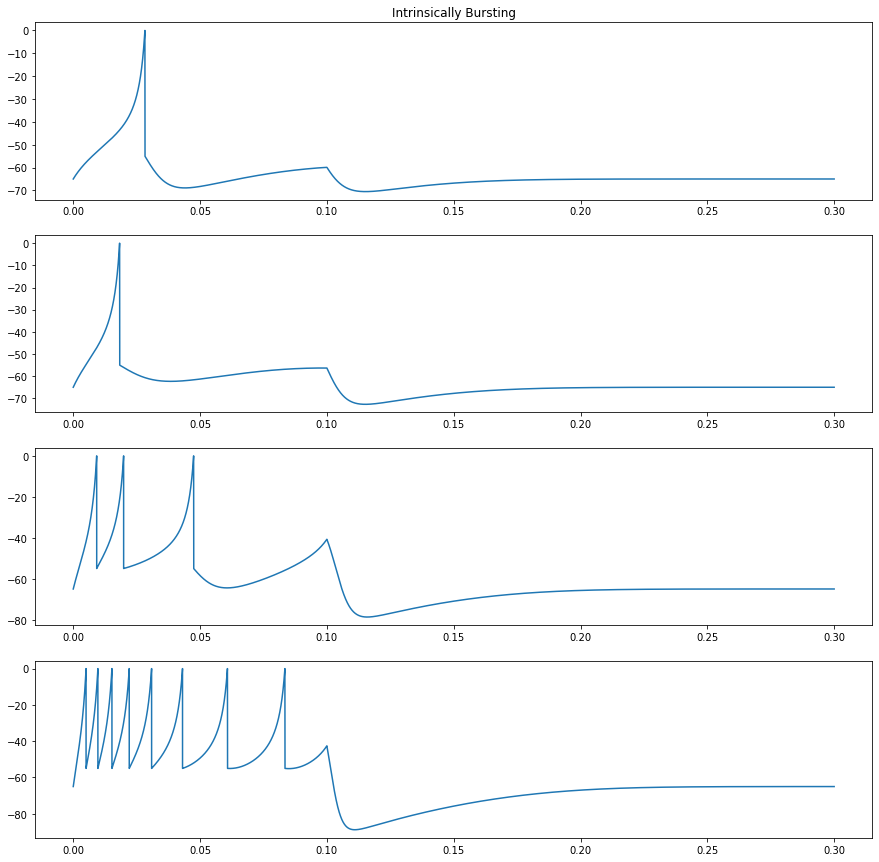

In [20]:
params = [RTN_burst, TC,CH,IB]
#for p in params:
model = None
model = VeryReducedModel(backend = 'RAW')

#print(FS)
times = []
#plt.clf()

model.set_attrs(params[0])

fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(15,15))
cnt = 0
ax[0].set_title("Intrinsically Bursting")
for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0
    #DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = 0
    iparams['injected_square_current']['duration'] = 100*pq.ms

    model.inject_square_current(iparams)
    #print(model.get_spike_count())
    ax[cnt].plot(model.get_membrane_potential().times,model.get_membrane_potential())
    cnt+=1
plt.show()
    


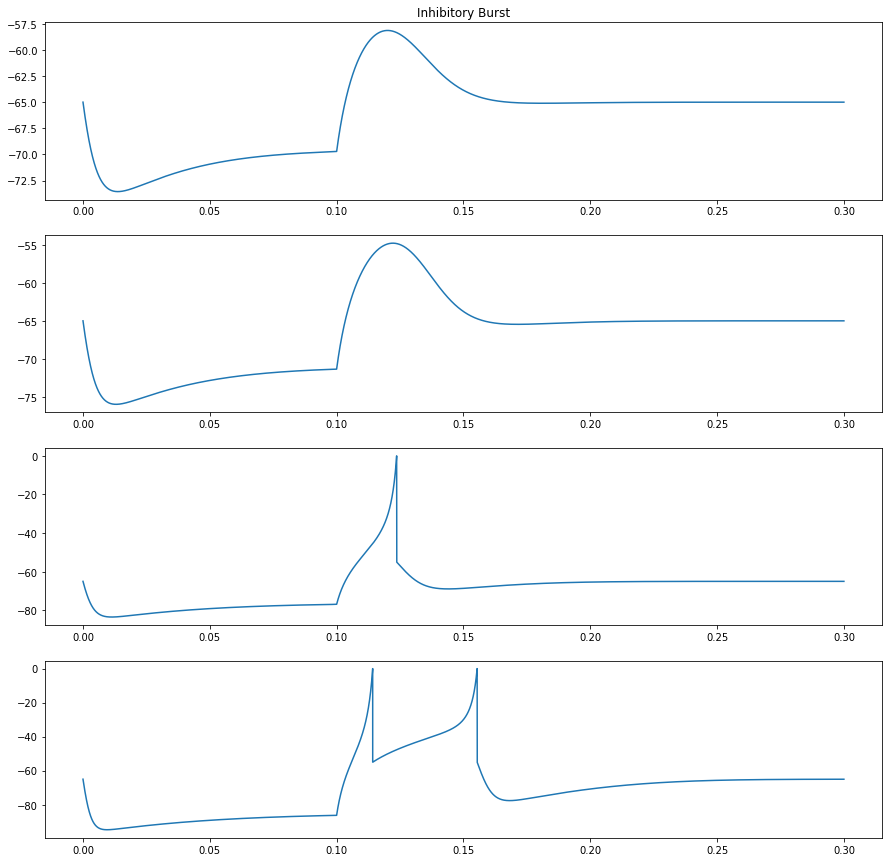

In [21]:
params = [RTN_burst, TC,CH,IB]
#for p in params:
model = None
model = VeryReducedModel(backend = 'RAW')

#print(FS)
times = []
#plt.clf()

model.set_attrs(params[0])

fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(15,15))
cnt = 0
ax[0].set_title("Inhibitory Burst")
for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = -current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0
    #DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = 0
    iparams['injected_square_current']['duration'] = 100*pq.ms

    model.inject_square_current(iparams)
    #print(model.get_spike_count())
    ax[cnt].plot(model.get_membrane_potential().times,model.get_membrane_potential())
    cnt+=1
plt.show()
    


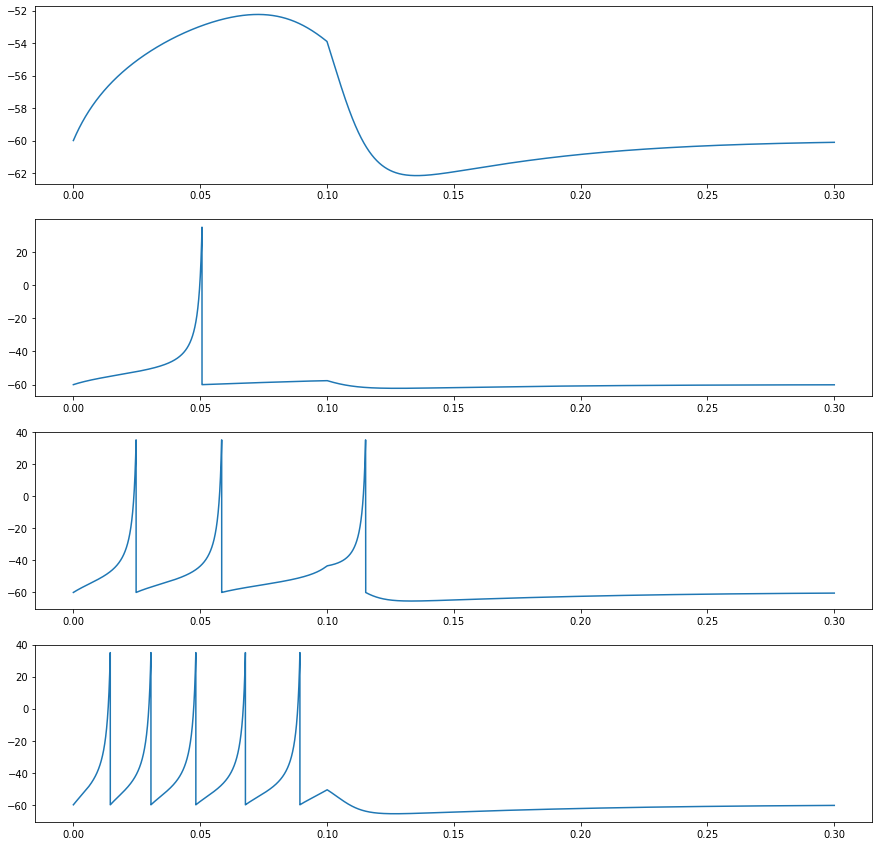

In [22]:
model.set_attrs(params[1])

fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(15,15))
cnt = 0
#IinRange = [30,50,90]
#tstop=720
for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0
    #DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = 0
    iparams['injected_square_current']['duration'] = tstop*pq.ms

    model.inject_square_current(iparams)
    #print(model.get_spike_count())
    ax[cnt].plot(model.get_membrane_potential().times,model.get_membrane_potential())
    cnt+=1
plt.show()
    

    

![izhi2003.png](izhi2003.png)

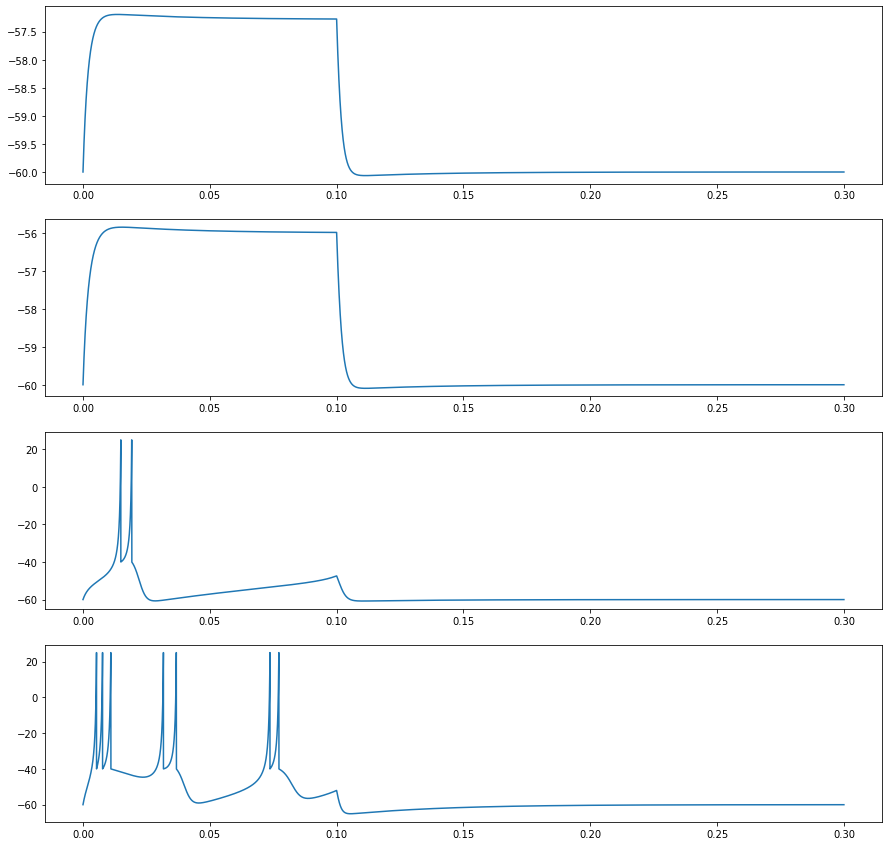

In [23]:
model.set_attrs(params[2])

fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(15,15))
cnt = 0
for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0
    #DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = 0
    iparams['injected_square_current']['duration'] = 100*pq.ms

    model.inject_square_current(iparams)
    #print(model.get_spike_count())
    ax[cnt].plot(model.get_membrane_potential().times,model.get_membrane_potential())
    cnt+=1
plt.show()

![izhi2003.png](izhi2003.png)

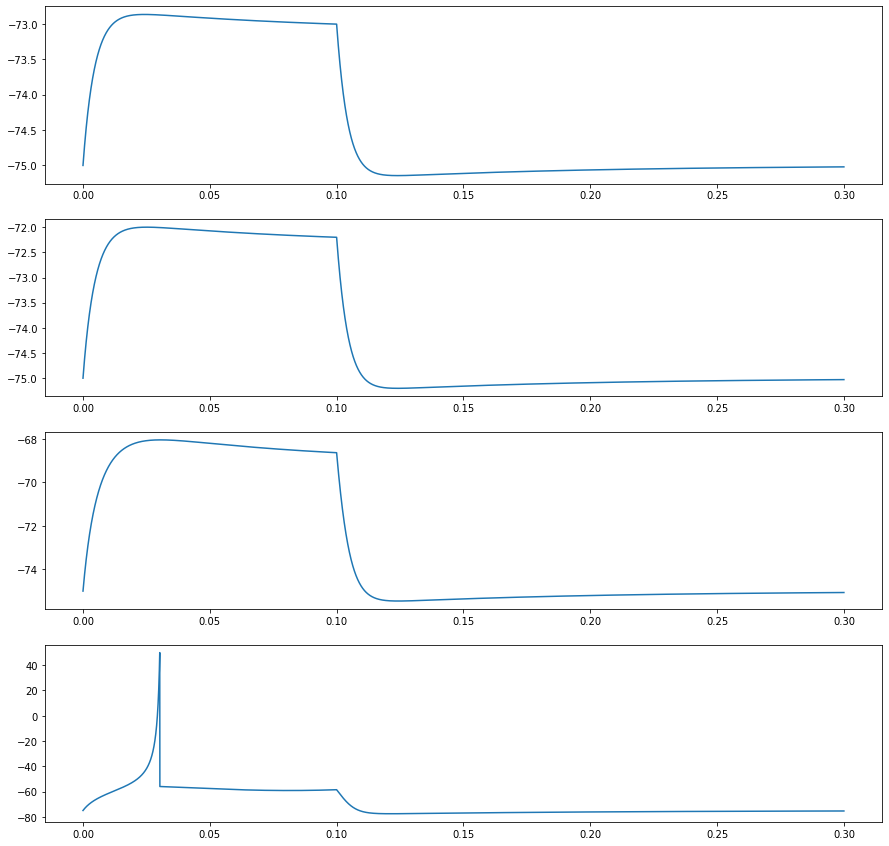

In [24]:
model.set_attrs(params[3])

fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(15,15))
cnt = 0
for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0
    #DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = 0
    iparams['injected_square_current']['duration'] = 100*pq.ms

    model.inject_square_current(iparams)
    #print(model.get_spike_count())
    ax[cnt].plot(model.get_membrane_potential().times,model.get_membrane_potential())
    cnt+=1
plt.show()

The following cells follow the Backend pattern RAW, NEURON, RAW, NEURON.

In [25]:

    #print(model.results['sim_time'], 'simulation')
    #times.append(model.results['sim_time'])#
#print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))    


{'C': 200, 'k': 1.6, 'vr': -60, 'vt': -50, 'a': 0.01, 'b': 15, 'c': -60, 'd': 10, 'vpeak': 35}
0
{'C': 200, 'k': 1.6, 'vr': -60, 'vt': -50, 'a': 0.01, 'b': 15, 'c': -60, 'd': 10, 'vpeak': 35}
0
{'C': 200, 'k': 1.6, 'vr': -60, 'vt': -50, 'a': 0.01, 'b': 15, 'c': -60, 'd': 10, 'vpeak': 35}
0
{'C': 200, 'k': 1.6, 'vr': -60, 'vt': -50, 'a': 0.01, 'b': 15, 'c': -60, 'd': 10, 'vpeak': 35}
0
mean simulation time: nan. Total time: 0.0
{'C': 200, 'k': 1.6, 'vr': -60, 'vt': -50, 'vPeak': 35, 'a': 0.01, 'b': 15, 'c': -60, 'd': 10}


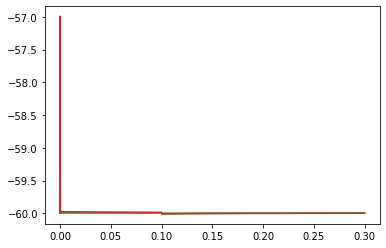

In [26]:
tstop = 100*pq.ms
IinRange = [73.2,100,200,400]

TCN['vpeak'] = TCN['vPeak']
TCN.pop('vPeak',None)
times = []
for current in IinRange:
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('NEURON'))
    model.attrs=TCN
    #model.set_attrs(**TCN)
    print(TCN)

    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA

    iparams['injected_square_current']['delay'] = 0*pq.ms
    iparams['injected_square_current']['duration'] = 100*pq.ms

    model.inject_square_current(iparams['injected_square_current'])
    print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    #print(model.results['sim_time'], 'simulation')
    #times.append(model.results['sim_time'])
print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))   
#plt.plot(model.results['vm'].times,model.results['vm'])
    
print(TC)

In [27]:
  # CH
tstop = 210
IinRange = [200,300,400,600]

{'C': 40, 'k': 0.25, 'vr': -65, 'vt': -45, 'vPeak': 0, 'a': 0.015, 'b': 10, 'c': -55, 'd': 50}
{'C': 40, 'k': 0.25, 'vr': -65, 'vt': -45, 'vPeak': 0, 'a': 0.015, 'b': 10, 'c': -55, 'd': 50}
0


KeyError: 'sim_time'

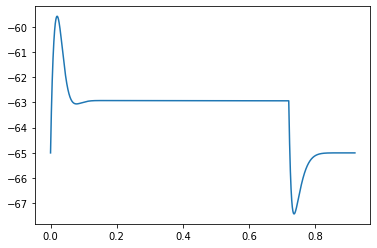

In [28]:
IinRange = [30,50,90]
tstop=720
print(RTN_burst)
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model.attrs = RTN_burst
print(RTN_burst)
times = []
for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0
    #DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = 0*pq.ms
    iparams['injected_square_current']['duration'] = tstop*pq.ms

    model.inject_square_current(iparams['injected_square_current'])
    print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    times.append(model.results['sim_time'])

    print(model.results['sim_time'], 'simulation')    

In [ ]:
tstop = 210
IinRange = [290,370,500,550]
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model.set_attrs(CH)
times = []
for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0
    DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = int(DURATION)

    model.inject_square_current(iparams)
    print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    times.append(model.results['sim_time'])

print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))    
    

In [ ]:
tstop = 210
IinRange = [290,370,500,550]
try:
    CHN['vpeak'] = CHN['vPeak']
    CHN.pop('vPeak',None)
except:
    pass

for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0*pq.ms
    DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = DURATION
    model = None

    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('NEURON'))
    model.attrs = CHN
    model.inject_square_current(iparams['injected_square_current'])
    print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    # print(model.results['sim_time'], 'simulation')    
print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))    
    

In [ ]:
iparams = {}
iparams['injected_square_current'] = {}
iparams['injected_square_current']['amplitude'] = 200*pq.pA
#['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
DELAY = 0*pq.ms
DURATION = tstop*pq.ms
iparams['injected_square_current']['delay'] = DELAY
iparams['injected_square_current']['duration'] = DURATION

model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
#model.set_attrs(CHN)
model.set_attrs(CH)

model.inject_square_current(iparams)
print(model.get_spike_count())
plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())



Ignore the rest of cells


In [ ]:

model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model.set_attrs(mparams)

import seaborn as sns
from neuronunit.optimization.data_transport_container import DataTC
import os
print(dir(model._backend))#.attrs)




params = {}
params['injected_square_current'] = {}
params['injected_square_current']['amplitude'] = 52*pq.pA
DELAY = 100.0*pq.ms
DURATION = 1000.0*pq.ms
params['injected_square_current']['delay'] = DELAY
params['injected_square_current']['duration'] = DURATION

#first_two[0].observation['mean'] = 50*pq.pA

#first_two[1].observation['mean'] = 50*pq.ohm*1e6

#print(first_two)

score = first_two[1].judge(model,stop_on_error = False, deep_error = True)
print(score)
stuff = first_two[1].generate_prediction(model)
print(stuff)
print(model.get_spike_count(),'npsikes')
print(np.mean(model.get_membrane_potential()),'mean membrane potential')


In [ ]:
score = first_two[1].judge(model,stop_on_error = False, deep_error = True)
print(score.prediction)
print(model.get_spike_count())

In [ ]:
score = first_two[0].judge(model,stop_on_error = False, deep_error = True)
print(score.prediction)
#print(model.get_spike_count())

In [ ]:

model = None
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))#,{'DTC':dtc}))
model.set_attrs(mparams)

prediction = all_tests[0].generate_prediction(model)
print(prediction)

prediction1 = all_tests[1].generate_prediction(model)
print(prediction1)

In [ ]:

cnt = 0
scores = []
tests_,all_tests, observation,suite = opt.get_neab.get_tests()
#passive  = [ str('RestingPotentialTest'), str('CapacitanceTest'), str('TimeConstantTest'), str('InputResistanceTest') ]
#firing_tests =  [ t for t in all_tests if str(t) not in passive ]

print(first_two)

for t in all_tests:
    score = t.judge(model,stop_on_error = False, deep_error = True)
        
    if cnt==0:
        model.rheobase = score.prediction['value']
        
        params = {}
        params['injected_square_current'] = {}
        params['injected_square_current']['amplitude'] = score.prediction['value']
        DELAY = 100.0*pq.ms
        DURATION = 1000.0*pq.ms
        params['injected_square_current']['delay'] = DELAY
        params['injected_square_current']['duration'] = DURATION
        model.params = params
    scores.append(score)
    print(score)
    print('score {0}'.format(score))
    if str('mean') in score.prediction.keys():
        print('observation {0}, prediction {1}'.format(t.observation['mean'],score.prediction['mean']))
    if str('value') in score.prediction.keys():
        print('observation {0}, prediction {1}'.format(t.observation['mean'],score.prediction['value']))
    cnt+=1
#http://www.physics

In [ ]:
import pandas as pd
import numpy as np
k_grid = np.logspace(-1.5,1,10)
#k_grid = np.logspace(-2,-1,10)
#k_grid = np.logspace(-1,1,10)


print(k_grid)

params = {}
params['a'] = 0.03
params['b'] = -2
params['C'] = 100
params['c'] = -50 
params['vr'] = -60
params['vt'] = -40
params['vPeak'] = 35
params['k'] = 0.7
params['d'] = 100
params['dt'] = 0.025
params['tMax'] = 1000.0;#   % max time [ms]
first_two = all_tests[0:2]
list_dics = []                                         
fig = plt.figure()
import copy
import pdb
tests_ = all_tests[0:2]
for k in k_grid:
    LEMS_MODEL_PATH = path_params['model_path']
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name=str('vanilla'),backend='NEURON')
    params['k'] = k
    model.set_attrs(params)

    scores = []
    for index,t in enumerate(first_two):
        print("k=%.2g; Test=%s" % (k,t))
        score = t.judge(model, stop_on_error=True, deep_error=False)
        print(score.prediction,'rheobase why not?')
        scores.append(score)

    for s in scores:
        agreement = {}
        agreement['k'] = k
        print('bad k', k)
        agreement['test'] = s.test
        try:
            agreement['observation'] = s.observation['mean'].rescale(s.test.units)
            agreement['prediction'] = s.prediction['value'].rescale(s.test.units)
            agreement['agreement'] = float(agreement['observation'])/float(agreement['prediction'])
        except Exception as e:
            print('error score skip because %s' % e)
            agreement['agreement'] = None
        list_dics.append(agreement)




In [ ]:
#pd.set_option('display.precision', 3)
df = pd.DataFrame(list_dics)
dfg = df.reset_index(drop=True)
#dfg = dfg.dropna()
#dfg
#how='all'
#dfg = df.reset_index(drop=nan)


import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
#display(dfg.style.background_gradient(cmap=cm,subset=['agreement']))
#df
#ax = df[df['test'].index % 2 == 0].plot(x='k',y='agreement',label='Rheobase')

ax = df[df['test'].index % 2 == 0].plot(x='k',y='agreement',label='Rheobase')
df[df['test'].index % 2 == 1].plot(x='k',y='agreement',label='InputRes', ax=ax)
plt.plot(k_grid,np.ones(k_grid.shape),'--')
#plt.xscale('log')
#plt.yscale('log')

plt.xscale('log')
plt.yscale('log')

In [ ]:
list_dics

In [ ]:
print(k_grid)

In [ ]:
k_grid = np.logspace(-1,0,10)


In [ ]:
print(k_grid)

In [ ]:

import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
#display(dfg.style.background_gradient(cmap=cm,subset=['agreement']))
#df

ax = df[df['test'].index % 2 == 0].plot(x='k',y='agreement',label='Rheobase')
#df[df['test'].index % 2 == 1].plot(x='k',y='agreement',label='InputRes', ax=ax)
plt.plot(k_grid,np.ones(k_grid.shape),'--')
plt.xscale('log')
plt.yscale('log')

In [ ]:
ax = df[df['test'].index % 2 == 0].plot(x='k',y='agreement',label='Rheobase')


In [ ]:
# tests that do well, 4th last to second last.
# rheobase.
ft_ = all_tests[-4:-2]
ft_.insert(0,all_tests[0]) 
print(ft_)
free_params = ['k','b']
from neuronunit.optimization import optimization_management as om
ga_out, DO = om.run_ga(mp,3,ft_,free_params=free_params)


In [ ]:
type2007.keys()

In [ ]:
for k, v in type2007.items():
    print(v)

In [ ]:
param_dict